# Introduction

This notebook studies a number of data sets on COVID-19 in Canada, published by Health Canada. The intention
is to reveal insights into vaccine distribution and circulating variants, specifically within the province of Newfoundland and Labrador. It will also demonstrate the effectiveness of a "hybrid" modelling approach for describing and predicting the progression of the disease within the province.

# Random Forest Regressor

The random forest regressor "is an ensemble machine learning algorithm used for regression tasks. It works by building multiple decision trees during training and outputs the mean prediction of the individual trees to provide the final result."<sup>1</sup>

# SIR

The SIR model "is a simple mathematical model used to describe the spread of infectious diseases in a population."<sup>1</sup> It divides the population into three separate compartments:

- Susceptible (the portion of the population that is not yet infected but is vulnerable to catching the disease),
- Infected (the portion of the population that is currently infected and can transmit the disease to those in the susceptible group),
- Recovered (the portion of the population that has recovered from the disease and is no longer susceptible, either due to immunity or death).

# A Hybrid Approach

## Plots

17:03:39 - cmdstanpy - INFO - Chain [1] start processing
17:03:39 - cmdstanpy - INFO - Chain [1] done processing
/opt/homebrew/Caskroom/miniconda/base/envs/jupyterlab/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


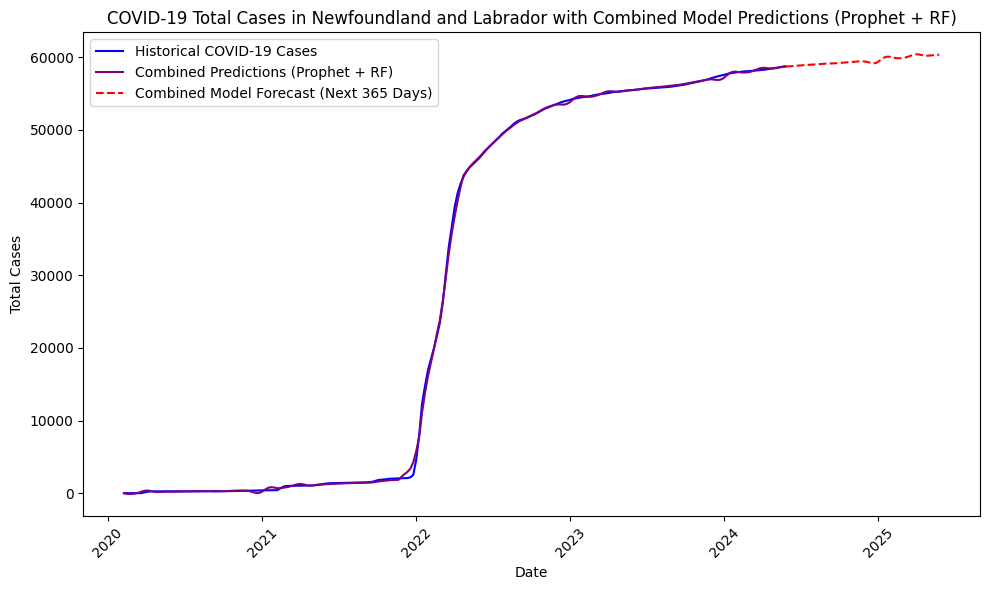

--- Prophet Model ---
Mean Squared Error (MSE): 260543.71742652703
Mean Absolute Error (MAE): 305.42747781176115
R² Score: 0.9996171047854195
--- Random Forest Model ---
Mean Squared Error (MSE): 24521.90224711109
Mean Absolute Error (MAE): 57.05973333333324
R² Score: 0.9999639625966975
--- Combined Model (Averaging Prophet and RF) ---
Mean Squared Error (MSE): 89795.41518109041
Mean Absolute Error (MAE): 165.0110296580105
R² Score: 0.9998680366001387


In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import timedelta

# Load dataset
df = pd.read_csv("https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv")

# Filter data for Newfoundland and Labrador and preprocess
df = df[df['prname'] == "Newfoundland and Labrador"]

# Convert 'date' to datetime and handle errors (invalid dates will be NaT)
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Drop rows with invalid or missing dates
df = df.dropna(subset=['date'])

# Sort the data by date
df = df.sort_values('date')

# Ensure 'totalcases' is numeric and drop any rows with missing values
df['totalcases'] = pd.to_numeric(df['totalcases'], errors='coerce')
df = df.dropna(subset=['totalcases'])

# Prepare the data for Facebook Prophet
df_prophet = df[['date', 'totalcases']]
df_prophet = df_prophet.rename(columns={'date': 'ds', 'totalcases': 'y'})

# Initialize and train the Prophet model
prophet_model = Prophet()
prophet_model.fit(df_prophet)

# Make predictions with Prophet for the next 365 days
future = prophet_model.make_future_dataframe(periods=365)  # Generate future dates
forecast_prophet = prophet_model.predict(future)

# Prepare the data for Random Forest (use days since the start of the data)
df['days'] = (df['date'] - df['date'].min()).dt.days  # Convert dates to number of days
X_rf = df[['days']]  # Features for Random Forest (days)
y_rf = df['totalcases']  # Target for Random Forest

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_rf, y_rf)

# Predict with Random Forest for the same historical data (predict for the current data)
rf_predictions = rf_model.predict(X_rf)

# For Prophet: Slice historical predictions
historical_prophet_predictions = forecast_prophet['yhat'][:len(df)].values

# Combine the predictions from Prophet and Random Forest for the historical period
historical_predictions = pd.DataFrame({
    'date': df['date'],
    'totalcases': df['totalcases'],  # Actual totalcases from the original dataset
    'prophet_pred': historical_prophet_predictions,  # Predictions for historical data from Prophet
    'rf_pred': rf_predictions  # Predictions for historical data from Random Forest
})

# Combined Model (using Prophet and RF predictions - simple averaging)
combined_predictions = (historical_prophet_predictions + rf_predictions) / 2

# Predictions for the next 365 days (future data)
rf_predictions_future = rf_model.predict(np.arange(df['days'].max() + 1, df['days'].max() + 366).reshape(-1, 1))  # Random Forest future predictions
prophet_predictions_future = forecast_prophet['yhat'][-365:].values  # Prophet future predictions

# Combine the future predictions from Prophet and Random Forest for the next 365 days
combined_predictions_future = (prophet_predictions_future + rf_predictions_future) / 2

# Plot the results
plt.figure(figsize=(10, 6))

# Plot historical data (actual cases)
plt.plot(df['date'], df['totalcases'], label='Historical COVID-19 Cases', color='blue')

# Plot combined predictions (averaged from Prophet and Random Forest) for historical period
plt.plot(df['date'], combined_predictions, label='Combined Predictions (Prophet + RF)', linestyle='-', color='purple')

# Plot combined model predictions for the next 365 days as a dashed line
future_dates = future['ds'][-365:]
plt.plot(future_dates, combined_predictions_future, label='Combined Model Forecast (Next 365 Days)', linestyle='--', color='red')

# Formatting
plt.xlabel('Date')
plt.ylabel('Total Cases')
plt.title('COVID-19 Total Cases in Newfoundland and Labrador with Combined Model Predictions (Prophet + RF)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Evaluation metrics for Combined Model (Averaging Prophet and RF)
print("--- Combined Model (Averaging Prophet and RF) ---")
mse_combined = mean_squared_error(df['totalcases'], combined_predictions)
mae_combined = mean_absolute_error(df['totalcases'], combined_predictions)
r2_combined = r2_score(df['totalcases'], combined_predictions)

print(f'Mean Squared Error (MSE): {mse_combined}')
print(f'Mean Absolute Error (MAE): {mae_combined}')
print(f'R² Score: {r2_combined}')


## Analysis

### Fitted Curve Plot



### Learning Curves Plot



### Synthetic Data Plot


# What are the most common variants of COVID-19 currently circulating within the province?

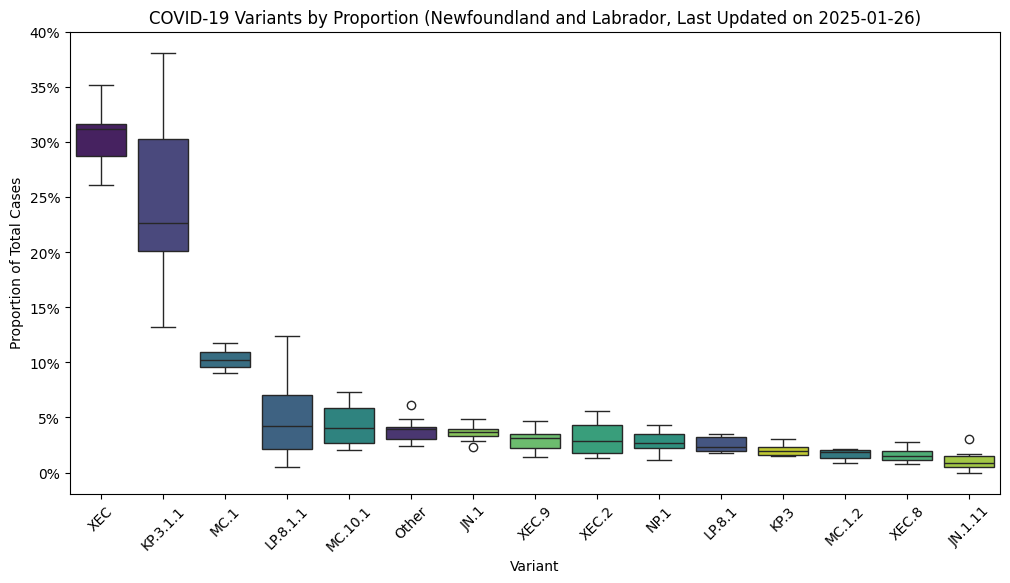

In [7]:
# Load the dataset.
variants_data = pd.read_csv("https://health-infobase.canada.ca/src/data/covidLive/covid19-epiSummary-variants.csv")

# Ensure the 'week of collection' is converted to datetime.
variants_data['week of collection'] = pd.to_datetime(variants_data['week of collection'])

# Divide every values in proportions by 100.
variants_data['proportions'] = variants_data['proportions'] / 100

# Sort variants by median proportion in descending order.
variant_medians = variants_data.groupby('variant')['proportions'].median().sort_values(ascending=False)
ordered_variants = variant_medians.index

# Boxplot of variant vs proportion, sorted by median in descending order with Viridis color palette.
plt.figure(figsize=(12, 6))
sns.boxplot(x='variant', y='proportions', data=variants_data, order=ordered_variants, palette='viridis', hue="variant")

last_updated = max(variants_data['week of collection'])

# Set plot title and labels.
plt.title(f"COVID-19 Variants by Proportion (Newfoundland and Labrador, Last Updated on {last_updated.date()})")
plt.xlabel("Variant")
plt.ylabel("Proportion of Total Cases")

# Format y-axis to show percentages.
formatter = FuncFormatter(lambda x, _: f'{x*100:.0f}%')  # Convert to percentage
plt.gca().yaxis.set_major_formatter(formatter)

# Rotate the x-ticks for better readability.
plt.xticks(rotation=45)

plt.show()




There are at least **13** known strains of COVID-19 circulating within the province. Of these some variants have higher proportions, particularly XEC and KP.3.1.1, indicating that these variants represent a larger share of the total cases in the province. The other variants have much lower proportions, representing a smaller portion of total cases. Several variants clearly have outlier values, as shown by the points outside the whiskers of the box plots. The interquartile ranges (IQRs) for variants such as XEC and KP.3.1.1 are relatively wide, indicating signficant variation in the numbers of their cases over time. The medians of variants such as XEC and KP.3.1.1 appear to be the highest; for most cases, these variants are more prevalent. The differences in proportions suggest that the XEC and KP.3.1.1 strains dominate the total case count, whereas the others are less prevalent.

# How many vaccines have been distributed within the province?

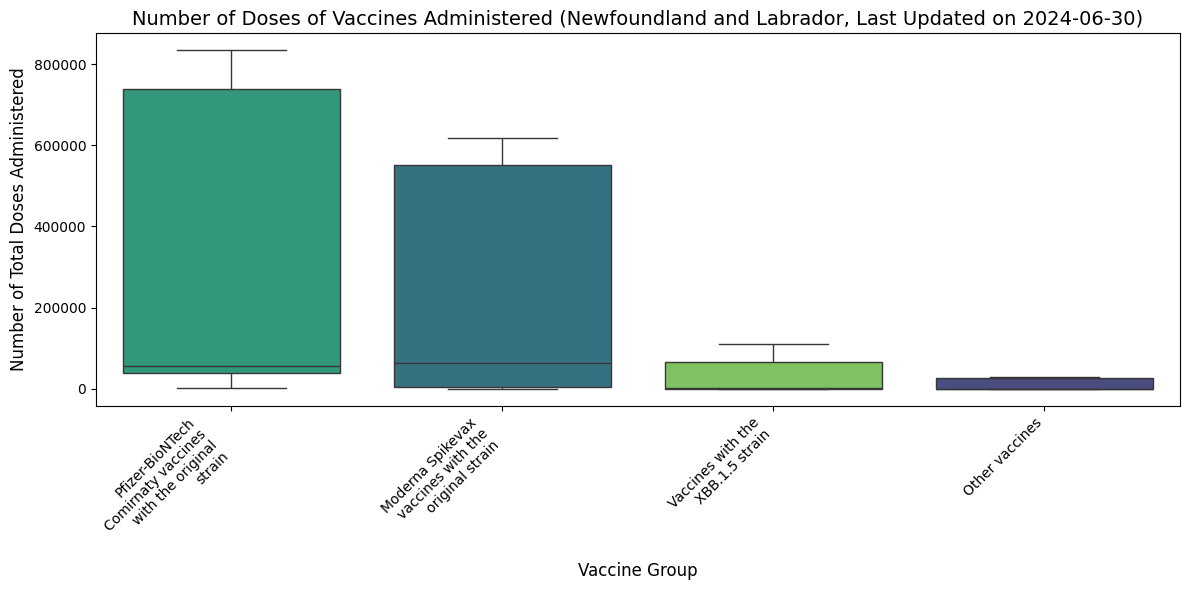

In [8]:
# Load the dataset.
vaccine_data = pd.read_csv("https://health-infobase.canada.ca/src/data/covidLive/vaccination-administration-bydosenumber_grouped.csv")

# Filter the data for Newfoundland and Labrador.
vaccine_data = vaccine_data[vaccine_data['prename'] == "Newfoundland and Labrador"]

# Filter "Total" and "Unknown" so that they are not displayed.
vaccine_data = vaccine_data[(vaccine_data['vaccine_group'] != "Total") & (vaccine_data['vaccine_group'] != "Unknown")]

# Select the relevant columns.
vaccine_data = vaccine_data[['vaccine_group', 'numtotal_totaldoses_admin', 'week_end']]

# Exclude specific vaccine groups.
vaccine_data = vaccine_data[(vaccine_data['vaccine_group'] != "Moderna Spikevax formulations") & (vaccine_data['vaccine_group'] != "Pfizer-BioNTech Comirnaty formulations")]

# Convert 'week_end' to datetime and calculate the most recent date.
vaccine_data['week_end'] = pd.to_datetime(vaccine_data['week_end'])
last_updated = vaccine_data['week_end'].max().date()

# Compute the order of vaccine groups by descending maximum doses administered.
order = vaccine_data.groupby('vaccine_group')['numtotal_totaldoses_admin'].max().sort_values(ascending=False).index

# Plotting the boxplot for vaccine group vs number of doses administered.
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='vaccine_group',
    y='numtotal_totaldoses_admin',
    data=vaccine_data,
    order=order,  # Use the computed order based on maximum values.
    palette="viridis",
    hue="vaccine_group",
)

# Add title and labels.
plt.title(f"Number of Doses of Vaccines Administered (Newfoundland and Labrador, Last Updated on {last_updated})", fontsize=14)
plt.xlabel("Vaccine Group", fontsize=12)
plt.ylabel("Number of Total Doses Administered", fontsize=12)

# Wrap x-axis labels and rotate them for better readability.
labels = plt.gca().get_xticklabels()

# Set tick positions and labels explicitly
tick_positions = plt.gca().get_xticks()  # Get the current tick positions
wrapped_labels = [textwrap.fill(label.get_text(), width=20) for label in labels]

# Apply the wrapped labels to the ticks
plt.gca().set_xticks(tick_positions)  # Ensure the ticks are set
plt.gca().set_xticklabels(wrapped_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()


The Pfizer-BioNTech Comirnaty vaccines with the original strain has the largest range of doses administered, with a significant number of doses falling in the 200,000 to 800,000 range. There is substantial variability in the data and high outliers, suggesting that there were some weeks in which exceptionally high numberes of doses were adminsitered. The Moderna Spikevax vaccines with the original strain has a slightly smaller distribution than Pfizer's but there is still significant variability. Vaccines with the XBB.1.5 strain have the smallest distribution, indicating fewer doses administered. The Pfizer-BioNTech vaccines with the original strain clearly has the largest number of doses administered, with the highest upper quartile. There are significant outliers in that group in particular, however, indicating that some weeks or months had notably higher numbers of doses administered than others. The Moderna vaccines with the original strain and formulations show more consistent administration over time.

# Conclusion

This notebook has illustrated the strength of combining the random forest regressor, SIR and XGBoost as a hybrid model for describing and predicting the spread of COVID-19, using real data from Newfoundland and Labrador, Canada. The model's predictive power and ability to provide concrete answers for policy makers give it a considerable advantage over other alternatives. This notebook has also explored some of the data sets available on COVID-19 in Canada, in order to provide insight into the vaccination effort, as well as the variants that currently circulate within the province. It remains to be seen what the final financial and social impacts of COVID-19 will be. It took nearly **1600 days** for the pandemic to reach a stage where it could be considered "over" and public health restrictions were finally lifted. During that time, many local businesses were forced to close their doors, unable to keep operating in such a restricted and uncertain environment. Modelling could potentially provide answers to the many questions that arise during a COVID-19 outbreak; how long will it last? What affects its spread the most? Are policies to contain its spread actually effective? All of these questions can be answered with modelling, but critically, the **right choice** of model must be made.

# References

$^1$ - OpenAI. (2025). ChatGPT (January 21 version) [Large language model]. https://chat.openai.com/chat